In [1]:
%cd /home/mkallel/explo/

import torch 
import numpy as np
import gpytorch 
import logging
import logging.config

from src.helpers import setup_experiment
from src.trainer import Trainer
from src.config import get_configs


logging.config.fileConfig('logging.conf')
# create root logger
logger = logging.getLogger()
print("hello")

from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

torch.set_num_threads(1)

/home/mkallel/explo


/home/mkallel/miniconda3/envs/bopt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


hello


In [2]:
def f(seed):

        

        torch.set_num_threads(1)
                
        #env_name = "CartPole-v1" ## Action kernel + State_norm looks very well for cartpole
        env_name = "Swimmer-v4" ##  State_norm stabilizes training 
        #env_name = "Hopper-v2"
        #env_name = "Walker2d-v3"
        kernel_name = "rbfstate" ## "linearstate" /"rbfstate"

        env_config,likelihood_config,kernel_config,mean_config,optimizer_config,trainer_config = get_configs(env_name,kernel_name)
        env_config["manipulate_state"] = False

       

        likelihood_config = {
                        "noise_hyperprior":gpytorch.priors.torch_priors.UniformPrior(a=0.01,b=0.05),
                        "noise_constraint":gpytorch.constraints.constraints.GreaterThan(0.01),
                        }


        kernel_config = {
                "use_ard":True,
                "kernel_name":kernel_name,
                "lengthscale_hyperprior":gpytorch.priors.torch_priors.GammaPrior(2,1),
                "lengthscale_constraint":gpytorch.constraints.constraints.Interval(0.1,10),
                "outputscale_hyperprior":gpytorch.priors.torch_priors.GammaPrior(2,1),
                "outputscale_constraint":gpytorch.constraints.constraints.GreaterThan(0.01),
                }

        mean_config = {
                        "advantage":False,
                }


        policy_config = {
                "add_layer":[],### can be empty or [8,7] for adding 2 layers with width 8,7  neurons respectively
                "add_bias":False,
        }

        trainer_config = {
                "n_steps":1000, 
                "report_freq":100,
                "save_best":False,
                "wandb_logger":True,
                "project_name":env_name,
                "run_name" : kernel_name+"_use_ard_"*kernel_config["use_ard"]+"_normalize_gradient_"*optimizer_config["normalize_gradient"]+str(seed),
                "wandb_config": {**env_config,**optimizer_config,**likelihood_config,**kernel_config,**policy_config}
        }


        model,objective_env,optimizer = setup_experiment(env_config,mean_config,kernel_config,likelihood_config,policy_config,optimizer_config,
                                        seed=seed)

        trainer = Trainer(model,objective_env,optimizer,**trainer_config)
        rslt= trainer.run()

        ### ADD LR SCHEDULAR  / FIX DISCRETIZATION ===> ENJOY WEEKEND :DDD

In [7]:
from multiprocessing import Pool
import wandb

n = 
seeds = np.random.randint(low=0,high=2**30,size=(n,))
seeds = [ int(i) for i in seeds]


if __name__ == '__main__':

    wandb.require("service")
    
    with Pool(processes=n) as p:
        p.map(f, seeds)

    

MathLog.src.helpers : WARNING : MLP dimensions : [8, 2]
 Gibo will use 32 last points to fit GP and 16 info samples
fixing seed to  57


wandb: Currently logged in as: mahdikallel. Use `wandb login --relogin` to force relogin


KeyboardInterrupt: 

In [6]:
type(seeds[0])

numpy.int64

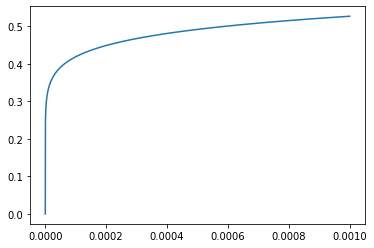

In [31]:
import scipy.stats as stats 
import numpy as np
import matplotlib.pyplot as plt

alpha = 1.1
beta = 1
x = np.linspace (0, 0.001, 2000) 
y1 = stats.gamma.pdf(x, a=alpha, scale=1/beta)
plt.plot(x,y1)

In [9]:
import torch

a = torch.ones((2))
torch.linalg.norm(a)**2





tensor(2.0000)

In [ ]:
print(a)

In [18]:
b = 1
a = {"a":1,
    "b":1}

SyntaxError: invalid syntax (2093608841.py, line 3)